In [1]:
import torch
import torch.nn as nn
from transformers import LlamaForCausalLM, AutoTokenizer
from mars_mmkg import *
from transformers import CLIPProcessor, CLIPModel
from torch_geometric.nn import NNConv
from PIL import Image

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0. Setting

0-1. CLIP

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

0-2. Llama2

In [4]:
llm_model_name="winglian/Llama-2-3b-hf" # light llama 
llm_model = LlamaForCausalLM.from_pretrained(llm_model_name)
llm_model = llm_model.to(device).eval()
llm_model.config.pad_token_id = llm_model.config.eos_token_id
llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_name)

0-3. MMKG

In [5]:
entity2text_path = "MarKG/entity2text.txt"
relation2text_path = "MarKG/relation2text.txt"
kg_path = "MarKG/wiki_tuple_ids.txt"
mars_img_embed_path = "mars_image_embeddings.h5"

In [6]:
entity_dict = get_entity_dict(entity2text_path)
relation_dict = get_relation_dict(relation2text_path)
mars_kg = MARS_KG(kg_path, entity_dict, relation_dict, clip_model, clip_processor, device)
mars_img_embed = get_all_img_embed(mars_img_embed_path)

In [7]:
KG_entities = mars_kg.KG_entities
KG_relations = mars_kg.KG_relations
print('Num of Entities:', len(KG_entities))
print('Num of relations:', len(KG_relations))

Num of Entities: 9903
Num of relations: 191


0-4. Retrieve subMMKG for Multimodal Analogical Reasoning 

In [8]:
def generate_prompt(entity1, entity2, relation):
    prompt = (
        f'"{entity1}" and "{entity2}" are related by the relation "{relation}". '
        f'Based on this, what is the text that has the same relation "{relation}" with the given image?'
    )
    return prompt

Question:  "food" and "grain" are related by the relation "made from material". Based on this, what is the text that has the same relation "made from material" with the given image?


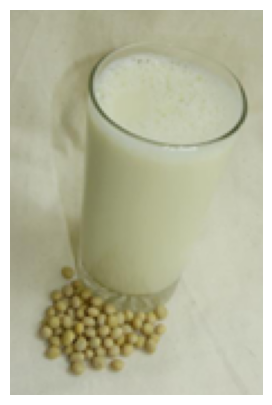

In [9]:
sample_entity1, sample_entity2, sample_relation = 'food', 'grain', 'made from material'
question_prompt = generate_prompt(sample_entity1, sample_entity2, sample_relation)
print('Question: ',question_prompt)

# visualization
sample_img_path = 'sample_img_soymilk.png'
sample_img_PIL = Image.open(sample_img_path)
plt.figure(figsize=(5, 5))
plt.imshow(sample_img_PIL)
plt.axis('off')  
plt.show()

/home/sha/Pyler/MKG_Analogy/MarT/dataset/mars_mmkg.py:182: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


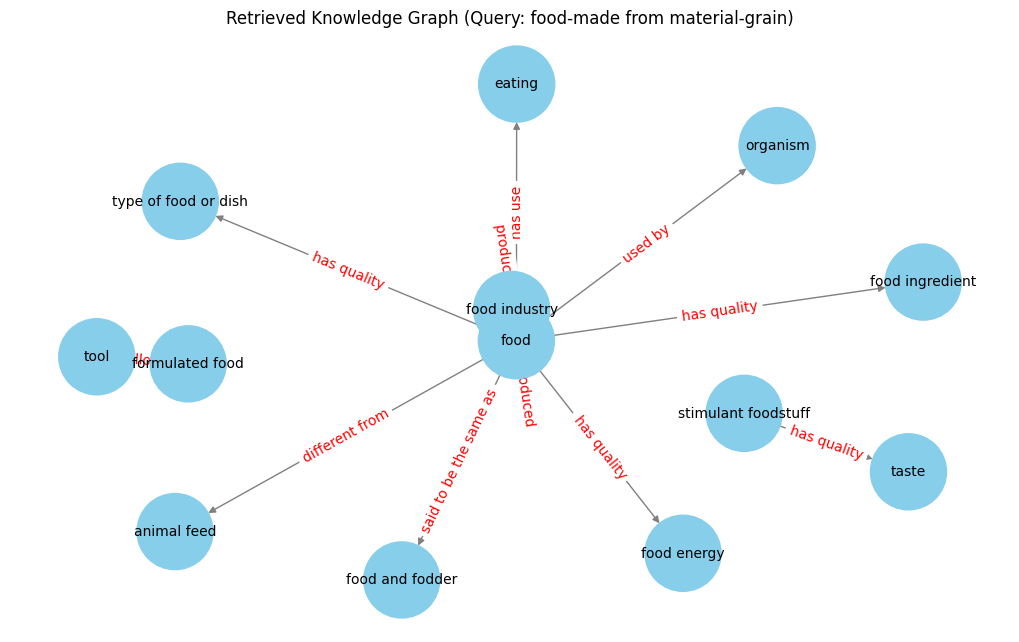

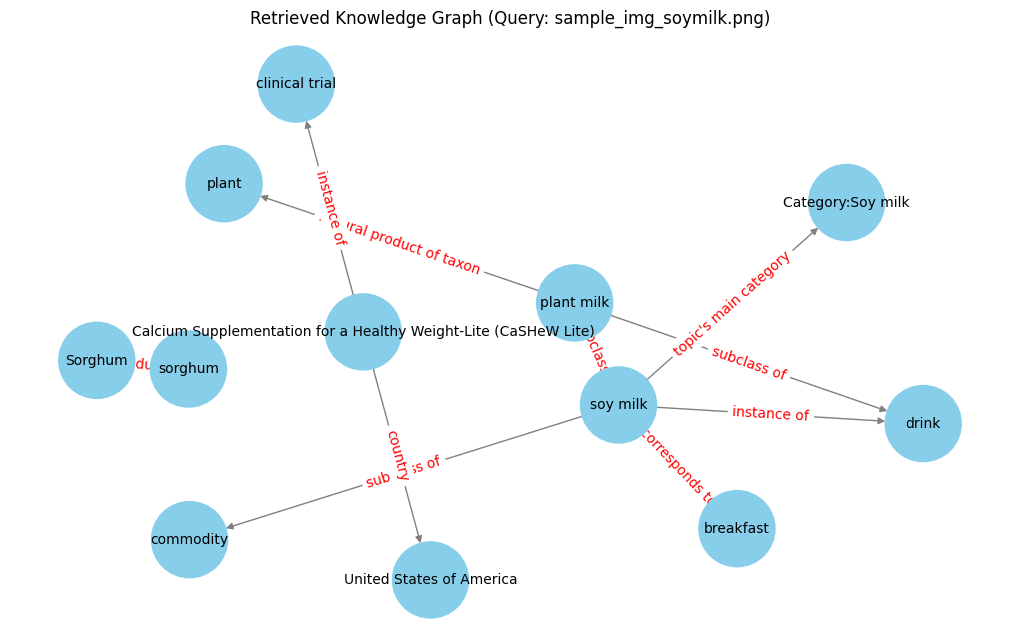

In [10]:
query1 = f'{sample_entity1}-{sample_relation}-{sample_entity2}'
sub_KG1 = mars_kg.get_sub_KG(query1)
draw_knowledge_graph(sub_KG1, query1)

query2 = sample_img_PIL
sub_KG2 = mars_kg.get_sub_KG(query2)
draw_knowledge_graph(sub_KG2, sample_img_path)

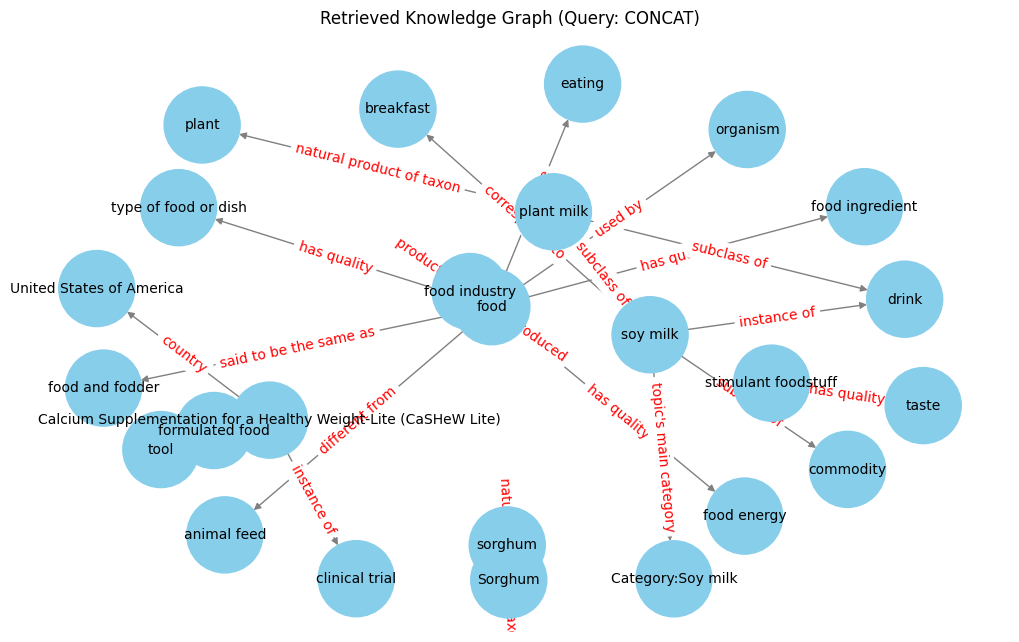

In [11]:
sub_KG = sub_KG1+sub_KG2
sub_MMKG = make_subMMKG(sub_KG, entity_dict)
draw_knowledge_graph(sub_KG, 'CONCAT')

In [12]:
for i, item in enumerate(sub_MMKG):
    print(i, item)

0 ('food', 'has quality', 'food ingredient')
1 ('food', 'different from', 'animal feed')
2 ('food industry', 'product or material produced', 'food')
3 ('food', 'used by', 'organism')
4 ('stimulant foodstuff', 'has quality', 'taste')
5 ('food', 'said to be the same as', 'food and fodder')
6 ('food', 'has quality', 'type of food or dish')
7 ('food', 'has quality', 'food energy')
8 ('formulated food', 'follow', 'tool')
9 ('food', 'has use', 'eating')
10 ('soy milk', "topic's main category", 'Category:Soy milk')
11 ('soy milk', 'subclass of', 'commodity')
12 ('soy milk', 'subclass of', 'plant milk')
13 ('Calcium Supplementation for a Healthy Weight-Lite (CaSHeW Lite)', 'instance of', 'clinical trial')
14 ('soy milk', 'instance of', 'drink')
15 ('Calcium Supplementation for a Healthy Weight-Lite (CaSHeW Lite)', 'country', 'United States of America')
16 ('plant milk', 'natural product of taxon', 'plant')
17 ('soy milk', 'corresponds to', 'breakfast')
18 ('plant milk', 'subclass of', 'drink')

---

#### 1. Language Encoder

In [13]:
def get_language_embedding(text, tokenizer, llama_model, device):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    with torch.no_grad():
        language_embed = llama_model.model.embed_tokens(input_ids)  # (B, T, D)  
    return language_embed

In [39]:
input_text = question_prompt
language_embed = get_language_embedding(input_text, llm_tokenizer, llm_model, device)

print(input_text)
print('Language Embedding shape:', language_embed.shape)

"food" and "grain" are related by the relation "made from material". Based on this, what is the text that has the same relation "made from material" with the given image?
Language Embedding shape: torch.Size([1, 43, 4096])


---

#### 2. Graph Encoder

2-1. node(entity) embedding

In [15]:
input_graph = sub_MMKG
node_list = get_entity_list(sub_MMKG)

node_embed_list = []
for node in node_list:
    if 'IMG:' in node:
        node_id = node[4:]
        node_embed = torch.from_numpy(mars_img_embed[node_id]).to(device)
    else:
        node_embed = get_clip_text_embeddings([node], clip_processor, clip_model, device)
    node_embed_list.append(node_embed)
node_embed_tensor = torch.cat(node_embed_list, dim=0)
print(node_embed_tensor.shape)

torch.Size([50, 512])


2-2. edge index, edge embedding

In [16]:
node2idx = {e: i for i, e in enumerate(node_list)}

all_edge_index = []
all_edge_embed = []
for h, r, t in input_graph:
    all_edge_index.append([node2idx[h], node2idx[t]])
    edge_embed = get_clip_text_embeddings([r], clip_processor, clip_model, device)
    all_edge_embed.append(edge_embed)

edge_index_tensor = torch.tensor(all_edge_index, dtype=torch.long).t().to(device)  # [2, num_edges]
edge_embed_tensor = torch.cat(all_edge_embed) # [num_edges, 512]

print('edge_index_tensor.shape:', edge_index_tensor.shape)
print('edge_embed_tensor.shape:', edge_embed_tensor.shape)

print(edge_index_tensor)

edge_index_tensor.shape: torch.Size([2, 45])
edge_embed_tensor.shape: torch.Size([45, 512])
tensor([[35, 35, 38, 35, 46, 35, 35, 35, 40, 35, 45, 45, 45,  0, 45,  0, 43, 45,
         43, 44, 23, 18,  4, 15, 14, 26, 16, 17, 20, 11, 10,  3,  7, 21, 12, 22,
         24, 25, 13,  2,  8,  6,  5, 19,  9],
        [39, 29, 35, 41, 47, 36, 49, 37, 48, 34,  1, 32, 43, 31, 33, 28, 42, 30,
         33, 27,  0,  1, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
         41, 42, 43, 44, 45, 46, 47, 48, 49]], device='cuda:0')


2-3. graph encoding (NNConv)

In [17]:
class EdgeMLP(nn.Module):
    def __init__(self, edge_dim, in_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(edge_dim, 1024),  # hidden layer
            nn.ReLU(),
            nn.Linear(1024, in_channels * out_channels)  
        )

    def forward(self, edge_attr):
        return self.mlp(edge_attr)

In [18]:
in_channels = 512
out_channels = 512
edge_dim = 512

edge_nn = EdgeMLP(edge_dim, in_channels, out_channels).to(device)
nnconv = NNConv(in_channels, out_channels, edge_nn).to(device)
graph_embed = nnconv(node_embed_tensor, edge_index_tensor, edge_embed_tensor)  # [num_nodes, out_channels]
graph_embed = graph_embed.unsqueeze(0)
print("Graph Embedding shape:", graph_embed.shape)

Graph Embedding shape: torch.Size([1, 50, 512])


---

#### 3. Vision Encoder

In [19]:
@torch.no_grad()
def get_clip_patch_embeddings(images, clip_processor, clip_model, device):
    inputs = clip_processor(images=images, return_tensors="pt").to(device)
    pixel_values = inputs["pixel_values"]  # [B, 3, 224, 224]

    outputs = clip_model.vision_model(pixel_values=pixel_values)
    patch_embeddings = outputs.last_hidden_state  # [B, num_patches+1, dim]
    patch_tokens = patch_embeddings[:, 1:, :]  # [B, num_patches, dim]
    return patch_tokens

In [20]:
input_visual = sample_img_PIL
visual_embed = get_clip_patch_embeddings([input_visual], clip_processor, clip_model, device)
print("Visual Embedding shape:", visual_embed.shape)

Visual Embedding shape: torch.Size([1, 49, 768])


---

#### 4. Multi-modal Prompt Generation 

In [42]:
class KGAdapter(nn.Module):
    def __init__(self, kg_dim=512, out_dim=4096):
        super().__init__()
        self.linear = nn.Linear(kg_dim, out_dim)  
        self.scale = out_dim ** 0.5

    def forward(self, kg_emb, language_emb):
        L = language_emb # (B, P_l, D)
        K = self.linear(kg_emb)  # (B, P_K, D)
        K_t = K.permute(0, 2, 1) # (B, D, P_K)

        # attention
        attn_score = (L @ K_t) / self.scale  # (B, P_l, P_K)
        attn_weight = F.softmax(attn_score, dim=-1)   # (B, P_l, P_K)
        out = attn_weight @ K  # (B, P_l, D)
        return out

In [43]:
class VisualAdapter(nn.Module):
    def __init__(self, vis_dim=768, out_dim=4096):
        super().__init__()
        self.linear = nn.Linear(vis_dim, out_dim)  
        self.scale = out_dim ** 0.5

    def forward(self, visual_emb, language_emb):
        L = language_emb # (B, P_l, D)
        V = self.linear(visual_emb)  # (B, P_v, D)
        V_t = V.permute(0, 2, 1) # (B, D, P_v)

        # attention
        attn_score = (L @ V_t) / self.scale  # (B, P_l, P_v)
        attn_weight = F.softmax(attn_score, dim=-1)   # (B, P_l, P_v)
        out = attn_weight @ V  # (B, P_l, D)
        return out

In [44]:
class MM_Prompt_Generator(nn.Module):
    def __init__(self, llm_dim=4096, kg_dim=512, vis_dim=768):
        super().__init__()
        # Adapters for KG and Vision
        self.kg_adapter = KGAdapter(kg_dim, llm_dim)
        self.vis_adapter = VisualAdapter(vis_dim, llm_dim)

    def forward(self, language_emb, kg_emb, visual_emb):
        kg_emb = self.kg_adapter(kg_emb, language_emb)
        visual_emb = self.vis_adapter(visual_emb, language_emb)

        # concat
        prompt = torch.cat([language_emb, kg_emb, visual_emb], dim=1) # (B, 3*P_l, D)
        return prompt

In [45]:
mmpg = MM_Prompt_Generator().to(device)
mm_prompt = mmpg(language_embed, graph_embed, visual_embed)
print(mm_prompt.shape)

torch.Size([1, 129, 4096])
